<a href="https://colab.research.google.com/github/krsmith/DS-Sprint-01-Dealing-With-Data/blob/master/module4-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [1]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [2]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [3]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.2 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=261.7008560760187, mobile=False), User(purchased=False, time_on_site=24.125473684342513, mobile=False), User(purchased=False, time_on_site=52.24630202027898, mobile=True), User(purchased=False, time_on_site=67.72303144869834, mobile=False), User(purchased=False, time_on_site=72.69001725114518, mobile=False), User(purchased=False, time_on_site=391.88584999520094, mobile=False), User(purchased=False, time_on_site=28.08162899178536, mobile=False), User(purchased=False, time_on_site=409.33046541015773, mobile=False), User(purchased=False, time_on_site=207.90576870482818, mobile=True), User(purchased=False, time_on_site=70.33149618329547, mobile=True)]


In [4]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,261.700856,False
1,False,24.125474,False
2,False,52.246302,True
3,False,67.723031,False
4,False,72.690017,False


In [5]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.8006393523736675,6.704075970745851,7.166265135937346,7.699095688601872,7.980822059528295,8.380269049637272,8.428296140809131,8.618079791332928,9.842050824793066,10.320922979556663,...,579.7143016118905,581.3613926603697,584.8282447475603,589.0579199398824,589.5171501965668,591.179254630029,592.6713895946627,593.7239134051315,594.5441708848855,596.5159984359989
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
True,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(5.21, 123.944]","(123.944, 242.087]","(242.087, 360.23]","(360.23, 478.373]","(478.373, 596.516]"
purchased,,,,,
False,289,298,150,39,46
True,62,61,47,1,7


In [7]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(5.21, 123.944]","(123.944, 242.087]","(242.087, 360.23]","(360.23, 478.373]","(478.373, 596.516]"
purchased,,,,,
False,0.823362,0.830084,0.761421,0.975,0.867925
True,0.176638,0.169916,0.238579,0.025,0.132075


In [8]:
# That seems counter to our hypothesis
# More time on the site seems to have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.916,0.790667
True,0.084,0.209333


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [1]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/invegat/DS-Sprint-01-Dealing-With-Data/master/module4-databackedassertions/persons.csv")
df.head()

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [2]:
print(df.describe())
print(df.info())

        Unnamed: 0          age       weight  exercise_time
count  1200.000000  1200.000000  1200.000000    1200.000000
mean    599.500000    48.396667   153.540833     134.910833
std     346.554469    18.166802    35.132182      85.548895
min       0.000000    18.000000   100.000000       0.000000
25%     299.750000    33.000000   125.000000      65.000000
50%     599.500000    48.000000   149.000000     122.000000
75%     899.250000    64.000000   180.250000     206.000000
max    1199.000000    80.000000   246.000000     300.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 4 columns):
Unnamed: 0       1200 non-null int64
age              1200 non-null int64
weight           1200 non-null int64
exercise_time    1200 non-null int64
dtypes: int64(4)
memory usage: 37.6 KB
None


In [3]:
# Looking at data with crosstabulation  pd.crosstab(a, [b, c], rownames=['a'], colnames=['b', 'c'])
pd.crosstab(df['exercise_time'], [df['age'], df['weight']], normalize='columns')

age             18                                              ...    80  \
weight         102  114  115  116  120  122  126  135  138  140 ...   186   
exercise_time                                                   ...         
0              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
1              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
2              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
3              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
4              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
5              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
6              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
7              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
8              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
9              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
10             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
11             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
12             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
13             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
14             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
15             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
16             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
17             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
18             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
19             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
20             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
21             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
22             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
23             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
24             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
25             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
26             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
27             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
28             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
30             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
...            ...  ...  ...  ...  ...  ...  ...  ...  ...  ... ...   ...   
270            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
271            0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0 ...   0.0   
272            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
273            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
274            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
275            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
276            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
277            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
278            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
279            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
280            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
281            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
282            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
283            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
284            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
285            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
286            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
287            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0

In [24]:
# Use panda.cut() to organize data into bins

age_bins = pd.cut(df['age'], bins=[18,30,42,54,68,80]) #8 equal-sized bins
time_bins = pd.cut(df['exercise_time'], bins=[0,75,150,225,300]) #10 equal-sized bins
weight_bins = pd.cut(df['weight'], bins=[100,130,160,190,220])

# Now show the data with crosstab in bins
ct_persons = pd.crosstab(time_bins, [age_bins, weight_bins],normalize='columns')

ct_persons

age             (18, 30]                                    (30, 42]  \
weight        (100, 130] (130, 160] (160, 190] (190, 220] (100, 130]   
exercise_time                                                          
(0, 75]         0.173333   0.113924   0.340909   0.580645       0.10   
(75, 150]       0.160000   0.215190   0.250000   0.322581       0.25   
(150, 225]      0.266667   0.405063   0.272727   0.096774       0.27   
(225, 300]      0.400000   0.265823   0.136364   0.000000       0.38   

age                                              (42, 54]             \
weight        (130, 160] (160, 190] (190, 220] (100, 130] (130, 160]   
exercise_time                                                          
(0, 75]         0.196970   0.255319   0.566667   0.098592   0.163636   
(75, 150]       0.151515   0.382979   0.400000   0.169014   0.181818   
(150, 225]      0.242424   0.297872   0.033333   0.183099   0.200000   
(225, 300]      0.409091   0.063830   0.000000   0.549296   0.454545   

age                                   (54, 68]                        \
weight        (160, 190] (190, 220] (100, 130] (130, 160] (160, 190]   
exercise_time                                                          
(0, 75]         0.279070   0.458333   0.180328   0.149425   0.346154   
(75, 150]       0.325581   0.500000   0.196721   0.241379   0.423077   
(150, 225]      0.348837   0.041667   0.377049   0.344828   0.173077   
(225, 300]      0.046512   0.000000   0.245902   0.264368   0.057692   

age                        (68, 80]                                   
weight        (190, 220] (100, 130] (130, 160] (160, 190] (190, 220]  
exercise_time                                                         
(0, 75]         0.519231   0.425926    0.37037   0.460317   0.571429  
(75, 150]       0.461538   0.407407    0.50000   0.444444   0.428571  
(150, 225]      0.019231   0.166667    0.12963   0.095238   0.000000  
(225, 300]      0.000000   0.000000    0.00000   0.000000   0.000000

In [6]:
import matplotlib.pyplot as plt
!pip install seaborn --upgrade
import seaborn as sns
print(sns.__version__)

Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.9.0)
0.9.0


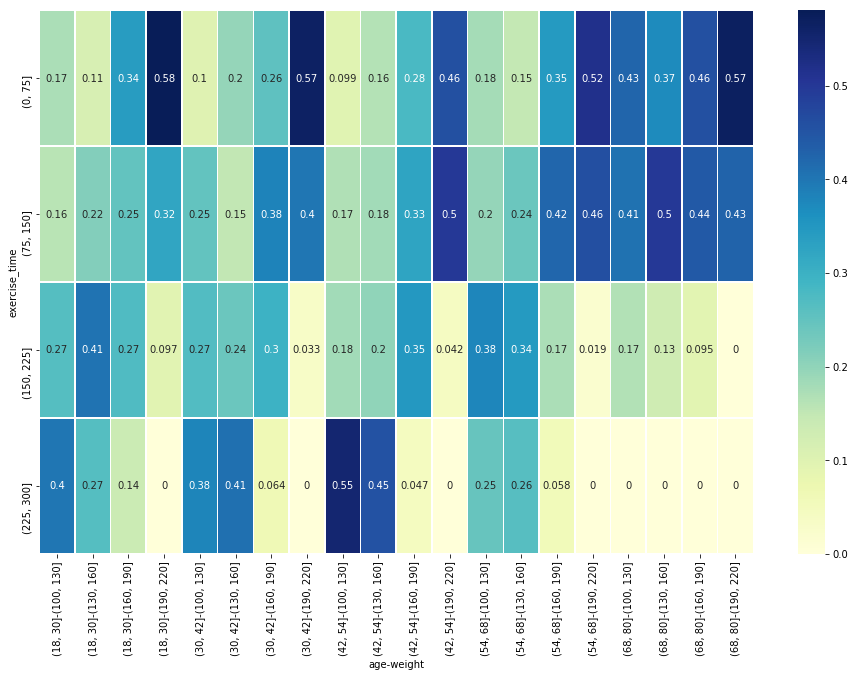

In [25]:
# Seaborn Heatmap for age/weight by exercise time

fig, ax = plt.subplots(figsize=(16,10))

sns.heatmap(ct_persons,annot=True,linewidths=.5,cmap="YlGnBu", ax=ax);

#Older age, disregarding weight, tends to exercise for less time.
#Higher weight, disregarding age, tends to exercise for less time.
#Younger age and lower weight tends to excercise for the most time.
    

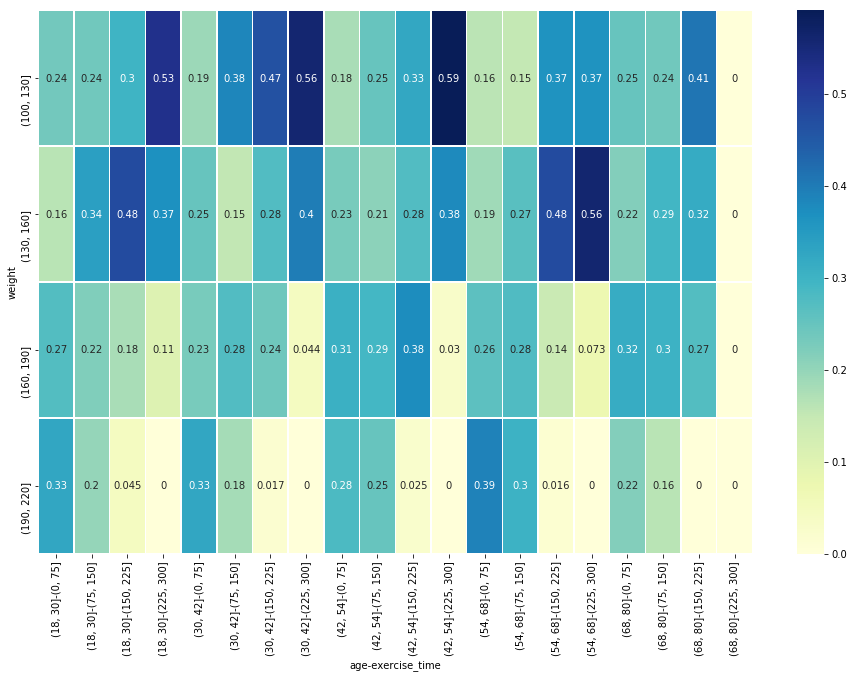

In [27]:
# Seaborn Heatmap for age/exercise time by weight
ct_weight = pd.crosstab(weight_bins, [age_bins, time_bins],normalize='columns')

fig, ax = plt.subplots(figsize=(16,10))

sns.heatmap(ct_weight,annot=True,linewidths=.5,cmap="YlGnBu", ax=ax);



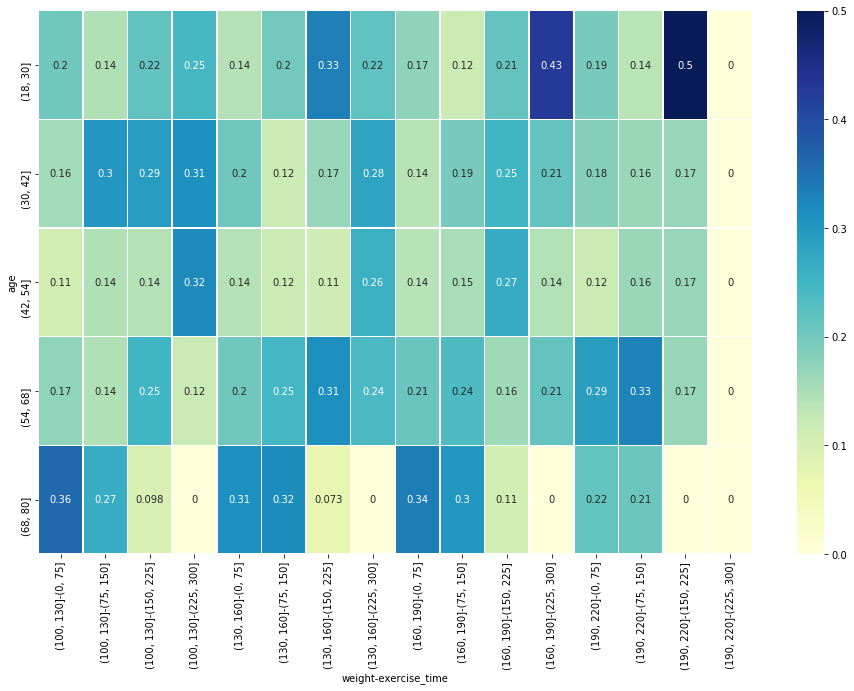

In [28]:
# Seaborn Heatmap for weight/exercise time by age
ct_age = pd.crosstab(age_bins, [weight_bins, time_bins],normalize='columns')

fig, ax = plt.subplots(figsize=(16,10))

sns.heatmap(ct_age,annot=True,linewidths=.5,cmap="YlGnBu", ax=ax);

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?

*All of the variables in this data are integers which represent a person's age, weight, and exercise time.*

2.  What are the relationships between the variables?

*The lower the age, regardless of weight, the more time a person would spend exercising. The higher the weight, regardless of age, the less time a person would spend exercising. Younger age & lower weight tends to excercise for more time.*

3.  Which relationships are "real", and which spurious?

*I would say that age and weight are spurious.*

*REAL: Higher weight = less exercise time.*

*REAL: Higher age = less exercise time.*

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)